# Seizure detection sandbox

## Workspace Preparation

In [1]:
# iEEG imports
from ieeg.auth import Session

# Scientific computing imports
import numpy as np
import scipy as sc
import pandas as pd
import json
from scipy.linalg import hankel
from tqdm import tqdm
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Imports for deep learning
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# OS imports
import os
from os.path import join as ospj
from os.path import exists as ospe
from utils import *
import sys
sys.path.append('/users/wojemann/iEEG_processing')


In [79]:
plt.rcParams['image.cmap'] = 'hot'

In [2]:
with open('config.json','r') as f:
    CONFIG = json.load(f)
usr = CONFIG["paths"]["iEEG_USR"]
passpath = CONFIG["paths"]["iEEG_PWD"]
datapath = CONFIG["paths"]["RAW_DATA"]
patient_table = pd.DataFrame(CONFIG["patients"]).sort_values('ptID')
rid_hup = pd.read_csv(ospj(datapath,'rid_hup.csv'))
pt_list = patient_table.ptID.to_numpy()

In [3]:
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  random.seed(seed)
set_seed(5210)

In [4]:
set_seed(5210)

In [5]:
pt = 'HUP235'

## Defining Model Architectures

## Pulling Ictal Data

In [6]:
 # Defining paths for saved data
raw_datapath = ospj(datapath,pt)
if not os.path.exists(ospj(raw_datapath, "seizures")):
    os.mkdir(ospj(raw_datapath, "seizures"))

In [7]:
seizure_times = pd.read_csv('../HUP235_seizure_times.csv')

In [8]:
# access iEEG
# with open('woj_ieeglogin.bin', 'r') as f:
#   session = Session('wojemann', f.read())
# ds = session.open_dataset('HUP235_phaseII')
# # if re.search('Cz|Fz|C3|C4|EKG',i)
# # get labels and time series info
# raw_labels = clean_labels(ds.get_channel_labels(),'HUP235')
# chn_labels = [l for l in raw_labels if l not in ['Cz','Fz','C03','C04','EKG01','EKG02']]

# timeseries = ds.get_time_series_details('LC01')

# #get the sampling frequency
# fs = timeseries.sample_rate

### Code for saving and preprocessing

In [9]:
# # # Iterate through each seizure and run Andy's preprocessing and save it
# for i_sz,row in seizure_times.iterrows():
#     if i_sz not in [0,5,9]:
#         continue
#     print(f"Saving seizure number: {i_sz}")
#     seizure,fs = get_iEEG_data(usr,'woj_ieeglogin.bin',
#                                 row.iEEG_ID,
#                                 (row.Onset-60)*1e6,
#                                 (row.Offset+60)*1e6,
#                                 chn_labels,
#                                 force_pull = True)
#     chs = seizure.columns.to_list()
#     ch_df = check_channel_types(chs)
#     # plot_iEEG_data(seizure,np.arange(len(seizure))/fs)
#     # Bipolar montage
#     seizure_bp_np,bp_ch_df = bipolar_montage(seizure.to_numpy().T,ch_df)
#     bp_ch = bp_ch_df.name.to_numpy()
#     # plot_iEEG_data(pd.DataFrame(seizure_bp_np.T,columns=bp_ch),np.arange(len(seizure))/fs)
#     # Bandpass filtering
#     b,a = sc.signal.butter(4,[3,58],btype='bandpass',fs = fs)
#     seizure_bp_filt = sc.signal.filtfilt(b,a,seizure_bp_np,axis=1)
#     # Down sampling
#     factor = 4
#     seizure_bpd = sc.signal.decimate(seizure_bp_filt,4).T
#     fsd = fs/4
#     seizure_bpd_df = pd.DataFrame(seizure_bpd,columns = bp_ch)
#     # plot_iEEG_data(pd.DataFrame(seizure_bpd,columns=bp_ch),np.arange(len(seizure_bpd))/fsd)
#     seizure_bpd_df.to_pickle(ospj(raw_datapath,"seizures",f"det256_seizure_{i_sz}_stim_{0}.pkl"))

## Training Unsupervised Models

In this section I need to create a model for each channel. The current plan is to pull ten seconds of data per channel and then train an autoregressive model per channel. Each of these models would be saved into a dictionary keyed to the channel name. Another idea would be to have just one model that operates on all channels at the same time and even allows cross talk. Starting with the second idea.
* identify a good 10 second window for training
    * 307651
* preprocess: bipolar, bandpass [3,58], decimate by 4
* save it
* train model
    * 1 second windows, .5 second overlap

### Code for saving and preprocessing

In [10]:
# print(f"Saving interictal training data")
# INTERTIME = 307651
# pt_ieeg = 'HUP235_phaseII'
# inter,fs = get_iEEG_data(usr,'woj_ieeglogin.bin',
#                             pt_ieeg,
#                             INTERTIME*1e6,
#                             (INTERTIME+10)*1e6,
#                             chn_labels,
#                             force_pull = True)
# chs = inter.columns.to_list()
# ch_df = check_channel_types(chs)
# # plot_iEEG_data(inter,np.arange(len(inter))/fs)
# # Bipolar montage
# inter_bp_np,bp_ch_df = bipolar_montage(inter.to_numpy().T,ch_df)
# bp_ch = bp_ch_df.name.to_numpy()
# # plot_iEEG_data(pd.DataFrame(inter_bp_np.T,columns=bp_ch),np.arange(len(inter))/fs)
# # Bandpass filtering
# b,a = sc.signal.butter(4,[3,58],btype='bandpass',fs = fs)
# inter_bp_filt = sc.signal.filtfilt(b,a,inter_bp_np,axis=1)
# # Down sampling
# factor = 4
# inter_bpd = sc.signal.decimate(inter_bp_filt,4).T
# fsd = fs/4
# inter_bpd_df = pd.DataFrame(inter_bpd,columns = bp_ch)
# # plot_iEEG_data(pd.DataFrame(inter_bpd,columns=bp_ch),np.arange(len(inter_bpd))/fsd)
# inter_bpd_df.to_pickle(ospj(raw_datapath,"seizures",f"det256_interictal.pkl"))

### Code for data formatting and training

#### data formatting

In [11]:
def NumWins(x,fs,winLen,winDisp): 
   return int(np.floor(1 + (len(x)/fs - winLen)/winDisp))

def MovingWinClips(x,fs,winLen,winDisp):
  # calculate number of windows and initialize receiver
  nWins = NumWins(x,fs,winLen,winDisp)
  samples = np.empty((nWins,winLen*fs))
  # create window indices - these windows are left aligned
  idxs = np.array([(winDisp*fs*i,(winLen+winDisp*i)*fs)\
                   for i in range(nWins)],dtype=int)
  # apply feature function to each channel
  for i in range(idxs.shape[0]):
    samples[i,:] = x[idxs[i,0]:idxs[i,1]]
  
  return samples



In [12]:
def prepare_segment(data, fs = 256,train_win = 12, pred_win = 1, w_size = 1, w_stride=0.5):
    data_ch = data.columns.to_list()
    data_np = data.to_numpy()
    train_win = 12
    pred_win = 1
    j = fs-(train_win+pred_win)
    nwins = NumWins(data_np[:,0],fs,w_size,w_stride)
    data_mat = torch.zeros((nwins,j,(train_win+pred_win),len(data_ch)))
    for k in range(len(data_ch)): # Iterating through channels
        samples = MovingWinClips(data_np[:,k],fs,1,0.5)
        for i in range(samples.shape[0]):
            clip = samples[i,:]
            mat = torch.tensor(hankel(clip[:j],clip[j:]))
            data_mat[i,:,:,k] = mat
    data_flat = data_mat.reshape((-1,train_win + pred_win,len(data_ch)))
    input_data = data_flat[:,:-1,:].float()
    target_data = data_flat[:,-1,:].float()
    return input_data, target_data

#### preparing training

In [13]:
inter = pd.read_pickle(ospj(raw_datapath,"seizures",f"det256_interictal.pkl"))
fs = 256

In [14]:
# Prepare input and target data for the LSTM
input_data,target_data = prepare_segment(inter)

dataset = TensorDataset(input_data, target_data)
dataloader = DataLoader(dataset, batch_size=100, shuffle=False)

# Instantiate the model
input_size = input_data.shape[2]
hidden_size = 100
output_size = input_data.shape[2]

In [15]:
# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1,:])
        return out
    
class LRModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LRModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        # Flatten the input along the 'sequence length' dimension
        x = x.squeeze()
        out = self.linear(x)
        return out


#### model initialization and training

In [16]:
# Initialize the model
model = LSTMModel(input_size, hidden_size, output_size)
print(model)
ccheck = torch.cuda.is_available()
if ccheck:
   model.cuda()
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

LSTMModel(
  (lstm): LSTM(85, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=85, bias=True)
)


In [17]:
# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    for inputs, targets in dataloader:
        if ccheck:
            inputs = inputs.cuda()
            targets = targets.cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 9:
      print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 229.2354
Epoch [20/100], Loss: 188.1290
Epoch [30/100], Loss: 149.5260
Epoch [40/100], Loss: 119.2736
Epoch [50/100], Loss: 95.3973
Epoch [60/100], Loss: 79.1253
Epoch [70/100], Loss: 66.6271
Epoch [80/100], Loss: 55.1248
Epoch [90/100], Loss: 46.0188
Epoch [100/100], Loss: 39.0405


## Seizure Detection

For generating predictions I have a couple options. The predict function could take in the entire seizure and break it up/turn it into batches, or take in one second at a time. For now let's do seizure at a time. The function should take in the model, clip, preprocessing parameters, and return a 3D tensor with channels x windows x j.

In [152]:
seizure = pd.read_pickle(ospj(raw_datapath,"seizures",f"det256_seizure_{0}_stim_{0}.pkl"))

In [153]:
train_win = 12
pred_win = 1
input_data, target_data = prepare_segment(seizure,fs,train_win,pred_win)

In [ ]:
def predict_sz(model, input_data, target_data,batch_size=1):
    dataset = TensorDataset(input_data,target_data)
    dataloader = DataLoader(dataset,batch_size=batch_size,shuffle=False)
    ccheck = torch.cuda.is_available()
    if ccheck:
        model.cuda()
    with torch.no_grad():
        model.eval()
        mse_distribution = []
        for inputs, targets in tqdm(dataloader):
            if ccheck:
                inputs = inputs.cuda()
                targets = targets.cuda()
            outputs = model(inputs)
            # mse = criterion(outputs, targets)
            mse = (outputs-targets)**2
            # mse_distribution.append(mse.item())
            mse_distribution.append(mse)
    return torch.cat(mse_distribution).cpu().numpy()

In [ ]:
outputs = predict_sz(model,input_data,target_data,400)

100%|██████████| 305/305 [00:01<00:00, 205.93it/s]


In [73]:
def repair_data(outputs,data,fs=256,train_win=12,pred_win=1,w_size=1,w_stride=.5):
    nwins = NumWins(data.to_numpy()[:,0],fs,w_size,w_stride)
    nchannels = data.shape[1]
    repaired = outputs.reshape((nwins,fs-(train_win + pred_win),nchannels))
    return repaired

In [74]:
seizure_mat = repair_data(outputs,seizure)

In [148]:
sz_prob = sc.ndimage.uniform_filter1d(np.mean(np.log(seizure_mat),1).T,20,axis=1)

In [149]:
first_detect = np.argmax(sz_prob>8,axis=1)
first_detect[first_detect == 0] = sz_prob.shape[1]
ch_sorting = np.argsort(first_detect)

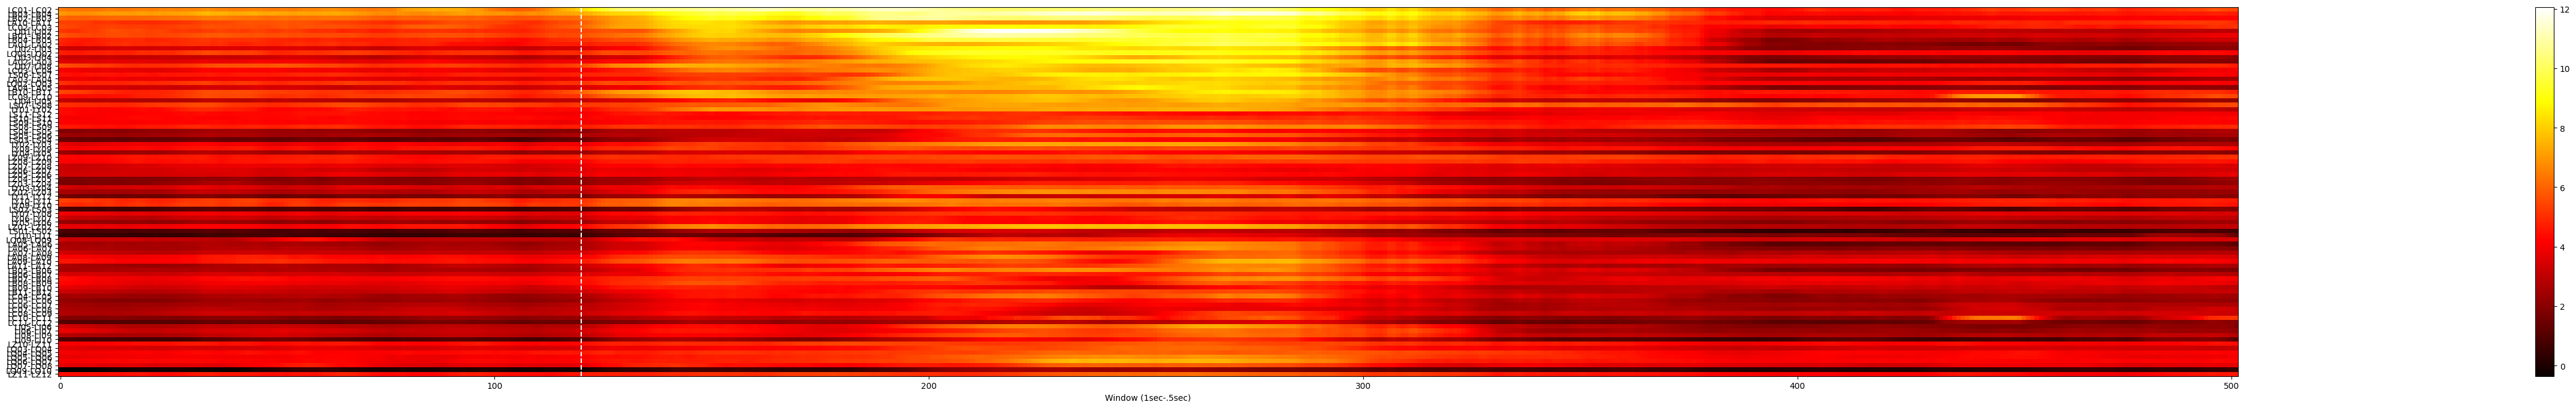

In [151]:
fig = plt.figure(figsize=(12,8))
plt.imshow(sz_prob[ch_sorting,:])
plt.axvline(120,linestyle = '--',color = 'white')
plt.xlabel('Window (1sec-.5sec)')
plt.yticks(np.arange(seizure.shape[1]),seizure.columns[ch_sorting])
plt.colorbar()
plt.show()
# plot_iEEG_data(seizure,np.arange(len(seizure))/fs)


In [139]:
np.where(sz_prob > 8)

(array([ 0,  0,  0, ..., 57, 57, 57]),
 array([187, 226, 227, ..., 293, 294, 295]))

In [ ]:
def predict(model, clip, ins = train_win, outs = 1):
    j = len(clip)-(ins + outs)
    data_mat = torch.tensor(hankel(clip[:j],clip[j:])).unsqueeze(2)
    dataset = TensorDataset(data_mat[:,:-outs,:].float(),data_mat[:,-outs,:].float())
    dataloader = DataLoader(dataset,shuffle=False)
    ccheck = torch.cuda.is_available()
    if ccheck:
        model.cuda()
    with torch.no_grad():
        model.eval()
        mse_distribution = []
        for inputs, targets in dataloader:
            if ccheck:
                inputs = inputs.cuda()
                targets = targets.cuda()
            outputs = model(inputs)
            mse = criterion(outputs, targets)
            mse_distribution.append(mse.item())
    return np.array(mse_distribution)

### 3 (7 pts)

#### 3a
Pull the first second of the first seizure in the csv, along with 1 second of interictal data starting at the given interictal time for the same seizure from `HUP235_phaseII` iEEG file. (2 pts)

In [ ]:
ictal = ds.get_data(seizure_times.loc[0,'Onset']*1e6,1*1e6,[chn_labels.index('LC01')])
ictal = sc.signal.decimate(ictal.T,2).T

inter = ds.get_data(seizure_times.loc[0,'Interictal']*1e6,1*1e6,[chn_labels.index('LC01')])
inter = sc.signal.decimate(inter.T,2).T

#### 3b
Generate mse distributions for each of the three clips (training clip, interictal clip, ictal clip) using your predict function from section 1 (1 pt).

In [ ]:
train_mse = predict(model,dsec)
inter_mse = predict(model,inter)
ictal_mse = predict(model,ictal)


#### 3c
Now, make three subplots in a 18 x 6 (W x H) figure: 1. plotting the interictal clip (blue) and ictal clip (red) with a legend (maintain this ictal/interictal color sceme through all three plots). 2. plot the loss of each clip with segments on the x axis and loss on the y axis. 3. Plot boxplots of the distributions of log-transformed MSE for the interictal and ictal clips, as well as an orange horizontal line at the 95th percentile of the loss the model generates on the TRAINING interictal clip (the one starting at 60000s). (4 pts)

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(18,6))
ax[0].plot(inter,c='blue',label='Interictal')
ax[0].plot(ictal,c='red',label='Ictal')
ax[0].legend()
ax[0].set_title('EEG Signal')
sns.scatterplot(inter_mse,c='blue',ax=ax[1])
sns.scatterplot(ictal_mse,c='red',ax=ax[1])
ax[1].set_title('Prediction Loss')
ax[1].set_ylabel('Loss (MSE)')
plot_data = {'interictal':inter_mse,'ictal':ictal_mse}
pal = {'interictal':'blue','ictal':'red'}
sns.boxplot(pd.DataFrame(plot_data),ax=ax[2],order=['interictal','ictal'],palette=pal)
ax[2].set_yscale('log')
ax[2].set_ylabel('Log Transformed MSE')
ax[2].set_title('Loss Distributions')
ax[2].axhline(np.percentile(train_mse,85),color='orange')

You can see from the plot, that the MSE values are going to make a great feature for detecting seizures.  Now that you've done this for one seizure on one channel, we're going to scale things up a little bit...

### 4 (15 pts)
We're going to deviate from the paper here for simplicity. Instead of using their unsupervised clustering algorithm, we're going to just use the 95th percentile of interictal loss from  as our decision boundary and use it to threshold the mean MSE value of new clips to predict ictal (above) or interictal (below).

#### 4a
To evaluate our model on it's ability to determine if any given one second clip comes from a seizure or is interictal, we need to write a new prediction function that converts an input clip into an ictal/interictal classifier. Try it out on the ictal clip from the previous question - it should predict Ictal! (3 pts)

In [ ]:
def clf(clip, model=model, threshold=np.percentile(inter_mse,95)):
    j = len(clip)-(train_win+1)
    data_mat = torch.tensor(hankel(clip[:j],clip[j:])).unsqueeze(2)

    with torch.no_grad():
        model.eval()
        inputs = data_mat[:,:-1,:].float()
        targets = data_mat[:,-1,:].float()
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            targets = targets.cuda()
        outputs = model(inputs)
        mse = criterion(outputs, targets)

    return mse.item() > threshold

In [ ]:
clf(ictal)

In [ ]:
ictal_clips = []
inter_clips = []
for i,row in seizure_times.iterrows():
    ictal = ds.get_data(row.Onset*1e6,np.floor(row.Offset-row.Onset)*1e6,[chn_labels.index('LB01')])
    dfs = fs/2
    ictal = sc.signal.decimate(ictal.T,2).T
    ictal_mat = np.reshape(ictal,(-1,int(1*dfs)))
    ictal_clips.append(ictal_mat)

    inter = ds.get_data(row.Interictal*1e6,np.floor(row.Offset-row.Onset)*1e6,[chn_labels.index('LB01')])
    inter = sc.signal.decimate(inter.T,2).T
    inter_clips.append(np.reshape(inter,(-1,int(1*dfs))))
ictal_clips = np.vstack(ictal_clips)
inter_clips = np.vstack(inter_clips)

We need to turn our ictal and interictal clips into a dataset that we can use to evaluate the capabilities of our model. Combine them into one matrix, and create a vector with the same number of rows that contains the target labels for each clip (1 for ictal, 0 for interictal). (1 pts)

In [ ]:
val_data = np.vstack([ictal_clips,inter_clips])
val_targets = np.vstack((np.ones((len(ictal_clips),1),dtype=bool),np.zeros((len(inter_clips),1),dtype=bool)))

In [ ]:
val_data.shape

#### 4c
Now, generate predictions on your new testing dataset. This might take a while (~1-2 min if you do one prediction at a time without a GPU, ~20 seconds with GPU) so use tqdm to print how long the prediction will take (1 pts).

In [ ]:
preds = np.zeros((len(val_targets),1))
for i in tqdm(range(len(val_data))):
  preds[i] = clf(val_data[i,:])

Print out the Accuracy, Precision, and Recall of our classifier as well as plotting the confusion matrix (2 pts)

In [ ]:
accuracy = lambda x,y: np.sum(x==y)/len(x)

In [ ]:
print(f"Accuracy: {accuracy(val_targets,preds)}")
print(f"Precision: {precision_score(val_targets,preds)}")
print(f"Recall: {recall_score(val_targets,preds)}")

ConfusionMatrixDisplay(confusion_matrix(val_targets,preds)).plot(cmap = 'plasma')